✅ Dataset loaded with 80 rows

                    min     max
BFC (%)             0.0     1.0
Temperature (°C)  200.0  1000.0
Duration (min)     20.0    60.0

🎯 Target total runs per replication: ~20
→ Factorial runs: 8
→ Axial runs: 6
→ Center points (factorial region): 3
→ Center points (axial region): 3

=== Generated 40-Run Face-Centered CCD Matrix (α = 1) ===
    Run  Replication  A_coded  B_coded  C_coded  BFC (%)  Temperature (°C)  \
0     1            1     -1.0     -1.0     -1.0      0.0             200.0   
1     2            1      1.0     -1.0     -1.0      1.0             200.0   
2     3            1     -1.0      1.0     -1.0      0.0            1000.0   
3     4            1      1.0      1.0     -1.0      1.0            1000.0   
4     5            1     -1.0     -1.0      1.0      0.0             200.0   
5     6            1      1.0     -1.0      1.0      1.0             200.0   
6     7            1     -1.0      1.0      1.0      0.0            1000.0   
7     8 

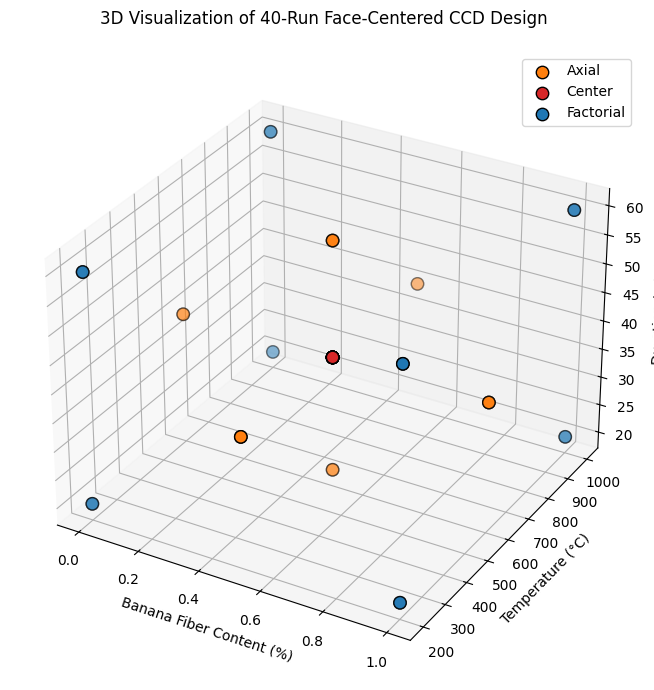


📊 3D CCD visualization saved as: CCD_3D_Visualization_40runs.png


In [1]:
# ===========================================================
#  Face-Centered Central Composite Design (CCD)
#  40-Run Matrix (2 Replications) + 3D Visualization + Summary
# ===========================================================
# Requirements:
# pip install pandas numpy matplotlib pyDOE2 openpyxl

import pandas as pd
import numpy as np
from pyDOE2 import ccdesign
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# -----------------------------
# 1. USER CONFIGURATION
# -----------------------------
DATA_PATH = "dataset5.xlsx"   # your dataset
SHEET_NAME = 0
OUT_DIR = "ccd_design_outputs_40runs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 2. LOAD DATA AND FACTOR RANGES
# -----------------------------
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
for f in factors:
    df[f] = pd.to_numeric(df[f], errors='coerce')

print(f"✅ Dataset loaded with {len(df)} rows\n")
print(df[factors].describe().T[['min', 'max']])

ranges = {f: (df[f].min(), df[f].max()) for f in factors}

# -----------------------------
# 3. DETERMINE DESIGN STRUCTURE (~20 RUNS PER REPLICATION)
# -----------------------------
k = 3  # number of factors
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20  # total per replication
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

print(f"\n🎯 Target total runs per replication: ~{target_total}")
print(f"→ Factorial runs: {factorial_runs}")
print(f"→ Axial runs: {axial_runs}")
print(f"→ Center points (factorial region): {center_factorial}")
print(f"→ Center points (axial region): {center_axial}")

# -----------------------------
# 4. GENERATE FACE-CENTERED CCD (α = 1)
# -----------------------------
ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
base_ccd_df = pd.DataFrame(ccd_face, columns=['A_coded', 'B_coded', 'C_coded'])

# Map coded values (-1, 0, +1) to actual experimental ranges
for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high) / 2
    half = (high - low) / 2
    base_ccd_df[f] = center + half * base_ccd_df.iloc[:, i]

# -----------------------------
# 5. CREATE 2 REPLICATIONS (40 TOTAL RUNS)
# -----------------------------
rep1_df = base_ccd_df.copy()
rep1_df['Replication'] = 1

rep2_df = base_ccd_df.copy()
rep2_df['Replication'] = 2

# Combine both replications
ccd_df_40 = pd.concat([rep1_df, rep2_df], ignore_index=True)
ccd_df_40['Run'] = np.arange(1, len(ccd_df_40) + 1)

# Reorder columns for clarity
cols = ['Run', 'Replication', 'A_coded', 'B_coded', 'C_coded'] + factors
ccd_df_40 = ccd_df_40[cols]

# -----------------------------
# 6. SAVE AND DISPLAY RESULTS
# -----------------------------
print("\n=== Generated 40-Run Face-Centered CCD Matrix (α = 1) ===")
print(ccd_df_40.round(3))

out_path = f"{OUT_DIR}/FaceCentered_CCD_40runs_2reps.xlsx"
ccd_df_40.to_excel(out_path, index=False)
print(f"\n💾 CCD matrix saved to: {out_path}")

# -----------------------------
# 7. DESIGN BREAKDOWN SUMMARY
# -----------------------------
total_runs = len(ccd_df_40)
factorial_runs = 2 ** k
axial_runs = 2 * k
center_runs = (target_total - (factorial_runs + axial_runs)) * 2  # replicated

print("\n=== CCD Design Breakdown ===")
print(f"→ Factorial points : {factorial_runs}")
print(f"→ Axial (star) points : {axial_runs}")
print(f"→ Center points (per replication): {center_factorial + center_axial}")
print(f"→ Total runs (2 reps): {total_runs}")

summary = pd.DataFrame({
    'Factor': factors,
    'Data Min': [ranges[f][0] for f in factors],
    'Data Max': [ranges[f][1] for f in factors],
    'CCD Min': [ccd_df_40[f].min() for f in factors],
    'CCD Max': [ccd_df_40[f].max() for f in factors]
})
summary_path = f"{OUT_DIR}/CCD_Range_Summary.xlsx"
summary.to_excel(summary_path, index=False)

print("\n=== CCD Range Summary ===")
print(summary.round(3))
print(f"\n📘 Range summary saved to: {summary_path}")

# -----------------------------
# 8. 3D SCATTER VISUALIZATION
# -----------------------------
def identify_point_type(row):
    if all(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Factorial'
    elif any(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]) and any(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Axial'
    elif all(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Center'
    else:
        return 'Mixed'

ccd_df_40['PointType'] = ccd_df_40.apply(identify_point_type, axis=1)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

colors = {'Factorial':'tab:blue', 'Axial':'tab:orange', 'Center':'tab:red', 'Mixed':'gray'}
for ptype, group in ccd_df_40.groupby('PointType'):
    ax.scatter(group['BFC (%)'], group['Temperature (°C)'], group['Duration (min)'],
               color=colors.get(ptype, 'gray'), s=80, label=ptype, edgecolor='k')

ax.set_xlabel('Banana Fiber Content (%)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Duration (min)')
ax.set_title('3D Visualization of 40-Run Face-Centered CCD Design', pad=20)
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/CCD_3D_Visualization_40runs.png", dpi=300)
plt.show()

print("\n📊 3D CCD visualization saved as: CCD_3D_Visualization_40runs.png")


✅ Dataset loaded with 40 rows

                    min     max
BFC (%)             0.0     1.0
Temperature (°C)  200.0  1000.0
Duration (min)     20.0    60.0

🎯 Target total runs per replication: ~20
→ Factorial runs: 8
→ Axial runs: 6
→ Center points (factorial region): 3
→ Center points (axial region): 3

=== Generated 40-Run Face-Centered CCD Matrix (α = 1, Randomized) ===
    Global_Run  Replication  Run_in_Rep  A_coded  B_coded  C_coded  BFC (%)  \
0            1            1           1     -1.0     -1.0     -1.0      0.0   
1            2            1           2      0.0      0.0      0.0      0.5   
2            3            1           3      0.0      0.0     -1.0      0.5   
3            4            1           4      1.0     -1.0     -1.0      1.0   
4            5            1           5      0.0      0.0      0.0      0.5   
5            6            1           6      1.0     -1.0      1.0      1.0   
6            7            1           7     -1.0      0.0      0.0 

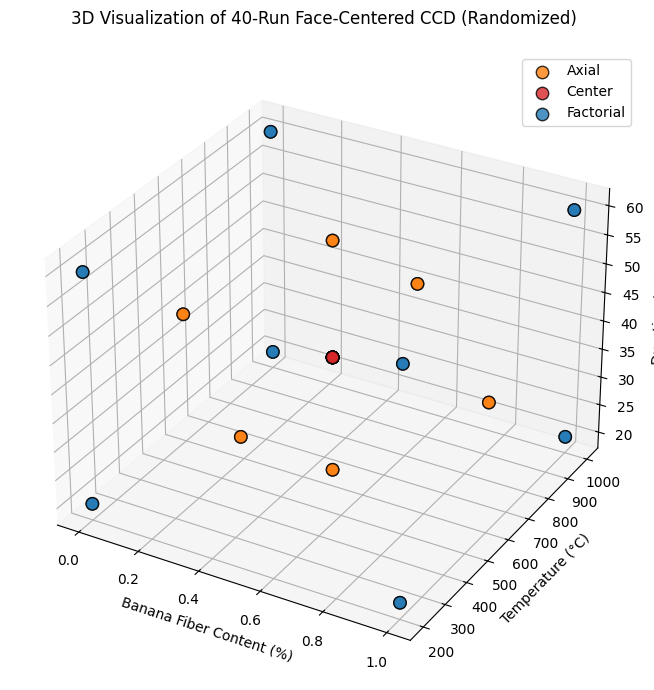


📊 3D CCD visualization saved as: CCD_3D_Visualization_40runs_randomized.png

✅ Completed: 40-Run Randomized CCD with 2 Replications Generated Successfully!


In [2]:
# ===========================================================
# 40-Run Face-Centered Central Composite Design (CCD)
# with 2 Replications, Randomized Run Order, and Visualization
# ===========================================================
# Requirements:
# pip install pandas numpy matplotlib pyDOE2 openpyxl

import pandas as pd
import numpy as np
from pyDOE2 import ccdesign
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# ------------------------------------------------------------
# 1️⃣ USER CONFIGURATION
# ------------------------------------------------------------
DATA_PATH = "dataset4.xlsx"   # Replace with your dataset file
SHEET_NAME = 0
OUT_DIR = "ccd_design_outputs_40runs_randomized"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2️⃣ LOAD DATA AND EXTRACT FACTOR RANGES
# ------------------------------------------------------------
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
for f in factors:
    df[f] = pd.to_numeric(df[f], errors='coerce')

print(f"✅ Dataset loaded with {len(df)} rows\n")
print(df[factors].describe().T[['min', 'max']])

ranges = {f: (df[f].min(), df[f].max()) for f in factors}

# ------------------------------------------------------------
# 3️⃣ DEFINE CCD STRUCTURE (~20 RUNS PER REPLICATION)
# ------------------------------------------------------------
k = 3
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

print(f"\n🎯 Target total runs per replication: ~{target_total}")
print(f"→ Factorial runs: {factorial_runs}")
print(f"→ Axial runs: {axial_runs}")
print(f"→ Center points (factorial region): {center_factorial}")
print(f"→ Center points (axial region): {center_axial}")

# ------------------------------------------------------------
# 4️⃣ GENERATE FACE-CENTERED CCD (α = 1)
# ------------------------------------------------------------
ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
base_ccd_df = pd.DataFrame(ccd_face, columns=['A_coded', 'B_coded', 'C_coded'])

# Map coded values (-1, 0, +1) to actual factor ranges
for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high) / 2
    half = (high - low) / 2
    base_ccd_df[f] = center + half * base_ccd_df.iloc[:, i]

# ------------------------------------------------------------
# 5️⃣ CREATE TWO REPLICATIONS (40 TOTAL RUNS)
# ------------------------------------------------------------
rep1_df = base_ccd_df.copy()
rep1_df['Replication'] = 1

rep2_df = base_ccd_df.copy()
rep2_df['Replication'] = 2

# Randomize each replication separately
rep1_df = rep1_df.sample(frac=1, random_state=42).reset_index(drop=True)
rep2_df = rep2_df.sample(frac=1, random_state=99).reset_index(drop=True)

# Add unique run IDs within replication
rep1_df['Run_in_Rep'] = np.arange(1, len(rep1_df) + 1)
rep2_df['Run_in_Rep'] = np.arange(1, len(rep2_df) + 1)

# Combine both replications
ccd_df_40 = pd.concat([rep1_df, rep2_df], ignore_index=True)
ccd_df_40['Global_Run'] = np.arange(1, len(ccd_df_40) + 1)

# Reorder columns
cols = ['Global_Run', 'Replication', 'Run_in_Rep', 'A_coded', 'B_coded', 'C_coded'] + factors
ccd_df_40 = ccd_df_40[cols]

# ------------------------------------------------------------
# 6️⃣ SAVE AND DISPLAY RESULTS
# ------------------------------------------------------------
print("\n=== Generated 40-Run Face-Centered CCD Matrix (α = 1, Randomized) ===")
print(ccd_df_40.round(3))

out_path = f"{OUT_DIR}/FaceCentered_CCD_40runs_2reps_randomized.xlsx"
ccd_df_40.to_excel(out_path, index=False)
print(f"\n💾 CCD matrix saved to: {out_path}")

# ------------------------------------------------------------
# 7️⃣ DESIGN SUMMARY
# ------------------------------------------------------------
total_runs = len(ccd_df_40)
factorial_runs = 2 ** k
axial_runs = 2 * k
center_runs = (target_total - (factorial_runs + axial_runs)) * 2

print("\n=== CCD Design Breakdown ===")
print(f"→ Factorial points : {factorial_runs}")
print(f"→ Axial (star) points : {axial_runs}")
print(f"→ Center points (per replication): {center_factorial + center_axial}")
print(f"→ Total runs (2 replications): {total_runs}")

summary = pd.DataFrame({
    'Factor': factors,
    'Data Min': [ranges[f][0] for f in factors],
    'Data Max': [ranges[f][1] for f in factors],
    'CCD Min': [ccd_df_40[f].min() for f in factors],
    'CCD Max': [ccd_df_40[f].max() for f in factors]
})
summary_path = f"{OUT_DIR}/CCD_Range_Summary.xlsx"
summary.to_excel(summary_path, index=False)

print("\n=== CCD Range Summary ===")
print(summary.round(3))
print(f"\n📘 Range summary saved to: {summary_path}")

# ------------------------------------------------------------
# 8️⃣ 3D VISUALIZATION OF DESIGN SPACE
# ------------------------------------------------------------
def identify_point_type(row):
    if all(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Factorial'
    elif any(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]) and any(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Axial'
    elif all(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Center'
    else:
        return 'Mixed'

ccd_df_40['PointType'] = ccd_df_40.apply(identify_point_type, axis=1)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

colors = {'Factorial':'tab:blue', 'Axial':'tab:orange', 'Center':'tab:red', 'Mixed':'gray'}
for ptype, group in ccd_df_40.groupby('PointType'):
    ax.scatter(group['BFC (%)'], group['Temperature (°C)'], group['Duration (min)'],
               color=colors.get(ptype, 'gray'), s=80, label=ptype, edgecolor='k', alpha=0.8)

ax.set_xlabel('Banana Fiber Content (%)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Duration (min)')
ax.set_title('3D Visualization of 40-Run Face-Centered CCD (Randomized)', pad=20)
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/CCD_3D_Visualization_40runs_randomized.png", dpi=300)
plt.show()

print("\n📊 3D CCD visualization saved as: CCD_3D_Visualization_40runs_randomized.png")

# ------------------------------------------------------------
print("\n✅ Completed: 40-Run Randomized CCD with 2 Replications Generated Successfully!")


In [3]:
# ===========================================================
# 40-Run Face-Centered Central Composite Design (CCD)
# Randomized + Descriptive Stats + RSM + Diagnostics + 3D Visualization
# ===========================================================
# pip install pandas numpy matplotlib seaborn statsmodels scikit-learn pyDOE2 openpyxl sympy

import pandas as pd
import numpy as np
from pyDOE2 import ccdesign
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sp
import os

# ------------------------------------------------------------
# 1️⃣ CONFIGURATION
# ------------------------------------------------------------
DATA_PATH = "dataset5.xlsx"    # <-- Your dataset
SHEET_NAME = 0
OUT_DIR = "ccd_full_analysis_40runs_randomized"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2️⃣ LOAD DATA
# ------------------------------------------------------------
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
for f in factors:
    df[f] = pd.to_numeric(df[f], errors='coerce')

print(f"✅ Dataset loaded with {len(df)} rows")
print(df[factors].describe().T[['min', 'max']])

ranges = {f: (df[f].min(), df[f].max()) for f in factors}

# ------------------------------------------------------------
# 3️⃣ GENERATE FACE-CENTERED CCD (α=1), RANDOMIZED, 2 REPS (40 RUNS)
# ------------------------------------------------------------
k = 3
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
base_ccd_df = pd.DataFrame(ccd_face, columns=['A_coded','B_coded','C_coded'])

for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high)/2
    half = (high - low)/2
    base_ccd_df[f] = center + half * base_ccd_df.iloc[:,i]

# Add replication & randomization
rep1_df = base_ccd_df.sample(frac=1, random_state=42).reset_index(drop=True)
rep1_df['Replication'] = 1
rep2_df = base_ccd_df.sample(frac=1, random_state=99).reset_index(drop=True)
rep2_df['Replication'] = 2

# Combine & reorder
ccd_df = pd.concat([rep1_df, rep2_df], ignore_index=True)
ccd_df['Run'] = np.arange(1, len(ccd_df)+1)
ccd_df = ccd_df[['Run','Replication','A_coded','B_coded','C_coded'] + factors]
ccd_df['Strength (MPa)'] = np.nan  # ready for lab entry

out_path = f"{OUT_DIR}/FaceCentered_CCD_40runs_2reps_randomized.xlsx"
ccd_df.to_excel(out_path, index=False)
print(f"\n💾 Randomized CCD (40 runs) saved to: {out_path}")

# ------------------------------------------------------------
# 4️⃣ DESCRIPTIVE STATISTICS
# ------------------------------------------------------------
desc = df.describe()
desc.loc['CV%'] = (desc.loc['std']/desc.loc['mean'])*100
desc.to_excel(f"{OUT_DIR}/Descriptive_Stats.xlsx")

print("\n=== Descriptive Statistics ===")
print(desc.round(3))

# ------------------------------------------------------------
# 5️⃣ SPLIT BY TEST TYPE
# ------------------------------------------------------------
df['TestType'] = df['Batch type'].apply(
    lambda x: 'Compressive' if 'COMPRESS' in str(x).upper()
    else ('Flexural' if 'FLEX' in str(x).upper() else 'Other')
)

comp_df = df[df['TestType']=='Compressive']
flex_df = df[df['TestType']=='Flexural']

print(f"\nCompressive rows: {len(comp_df)} | Flexural rows: {len(flex_df)}")

# ------------------------------------------------------------
# 6️⃣ RSM MODEL FUNCTIONS + DIAGNOSTICS
# ------------------------------------------------------------
def build_X(df_in, factors):
    X = pd.DataFrame({'const': np.ones(len(df_in))}, index=df_in.index)
    for f in factors:
        X[f] = df_in[f]
    for i in range(len(factors)):
        for j in range(i+1, len(factors)):
            X[f"{factors[i]}*{factors[j]}"] = df_in[factors[i]] * df_in[factors[j]]
    for f in factors:
        X[f"{f}^2"] = df_in[f]**2
    return X

def fit_rsm_clean(df_in, response='Strength (MPa)', label='Compressive'):
    print(f"\n--- Fitting RSM for {label} ---")
    df_clean = df_in.replace([np.inf, -np.inf], np.nan).dropna(subset=[response] + factors)
    if len(df_clean) < 10:
        print(f"⚠️ Not enough valid data for {label}.")
        return None, None, None

    X = build_X(df_clean, factors)
    y = df_clean[response]
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Diagnostics: Residuals vs Fitted
    resid, fitted = model.resid, model.fittedvalues
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=fitted, y=resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{label} - Residuals vs Fitted")
    plt.xlabel("Fitted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_Residuals_vs_Fitted.png", dpi=300)
    plt.close()

    # QQ Plot
    sm.qqplot(resid, line='45', fit=True)
    plt.title(f"{label} - QQ Plot")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_QQPlot.png", dpi=300)
    plt.close()

    # VIF
    vif = pd.DataFrame({
        'Term': X.drop(columns='const').columns,
        'VIF': [variance_inflation_factor(X.drop(columns='const').values, i)
                for i in range(X.drop(columns='const').shape[1])]
    })
    print("\n--- VIF ---")
    print(vif.round(3))

    # Metrics
    y_pred = model.fittedvalues
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)

    return model, df_clean, {'R2': r2, 'RMSE': rmse, 'MAE': mae}

comp_model, comp_clean, comp_metrics = fit_rsm_clean(comp_df, label='Compressive')
flex_model, flex_clean, flex_metrics = fit_rsm_clean(flex_df, label='Flexural')

# ------------------------------------------------------------
# 7️⃣ SYMBOLIC EQUATION EXPORT
# ------------------------------------------------------------
def export_rsm_equation(model, label):
    if model is None: return ""
    coeffs = model.params.to_dict()
    A,B,C = sp.symbols('A B C')
    eq = coeffs['const']
    for k,v in coeffs.items():
        if k=='const': continue
        if 'BFC' in k and '*' not in k and '^' not in k:
            eq += v*A
        elif 'Temperature' in k and '*' not in k and '^' not in k:
            eq += v*B
        elif 'Duration' in k and '*' not in k and '^' not in k:
            eq += v*C
        elif '*Temperature' in k and '*Duration' not in k:
            eq += v*A*B
        elif '*Duration' in k and 'BFC' in k:
            eq += v*A*C
        elif 'Temperature' in k and '*Duration' in k:
            eq += v*B*C
        elif 'BFC' in k and '^2' in k:
            eq += v*A**2
        elif 'Temperature' in k and '^2' in k:
            eq += v*B**2
        elif 'Duration' in k and '^2' in k:
            eq += v*C**2
    eq = sp.expand(eq)
    return f"\n{label} Model:\nY = {sp.pretty(eq, use_unicode=True)}\n"

equations = export_rsm_equation(comp_model, "Compressive Strength")
equations += export_rsm_equation(flex_model, "Flexural Strength")

with open(f"{OUT_DIR}/RSM_Equations.txt","w") as f:
    f.write(equations)
print("\n📘 Equations exported successfully!")

# ------------------------------------------------------------
# 8️⃣ 3D SURFACE + CONTOUR + OPTIMUM
# ------------------------------------------------------------
def plot_surface_with_optimum(model, df_in, label):
    if model is None or df_in is None:
        return
    f1, f2, f3 = factors
    F1, F2 = np.meshgrid(np.linspace(df_in[f1].min(), df_in[f1].max(), 40),
                         np.linspace(df_in[f2].min(), df_in[f2].max(), 40))
    f3_val = df_in[f3].mean()

    DF = pd.DataFrame({
        'const': 1,
        f1: F1.ravel(),
        f2: F2.ravel(),
        f3: f3_val,
        f"{f1}*{f2}": (F1*F2).ravel(),
        f"{f1}*{f3}": (F1*f3_val).ravel(),
        f"{f2}*{f3}": (F2*f3_val).ravel(),
        f"{f1}^2": (F1**2).ravel(),
        f"{f2}^2": (F2**2).ravel(),
        f"{f3}^2": (f3_val**2)
    })
    preds = model.predict(DF)
    Z = preds.values.reshape(F1.shape)

    idx = np.unravel_index(np.argmax(Z), Z.shape)
    opt_x, opt_y, opt_z = F1[idx], F2[idx], Z[idx]

    # 3D Plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(F1, F2, Z, cmap=cm.viridis, alpha=0.8)
    ax.scatter(opt_x, opt_y, opt_z, color='red', s=60, label=f'Optimum ({opt_z:.2f} MPa)')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_zlabel("Predicted Strength (MPa)")
    ax.set_title(f"{label} - 3D Surface (Duration={f3_val:.1f} min)")
    ax.legend()
    plt.savefig(f"{OUT_DIR}/{label}_3D_Surface.png", dpi=300)
    plt.close()

    # Contour Plot
    plt.figure(figsize=(7,6))
    cp = plt.contourf(F1, F2, Z, cmap='viridis', levels=30)
    plt.scatter(opt_x, opt_y, color='red', label=f'Optimum ({opt_z:.2f} MPa)')
    plt.colorbar(cp, label="Predicted Strength (MPa)")
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"{label} - Contour Plot (Duration={f3_val:.1f} min)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_Contour.png", dpi=300)
    plt.close()

    print(f"✅ {label} Optimum: {f1}={opt_x:.3f}, {f2}={opt_y:.1f}, Predicted={opt_z:.3f} MPa")

plot_surface_with_optimum(comp_model, comp_clean, "Compressive Strength")
plot_surface_with_optimum(flex_model, flex_clean, "Flexural Strength")

# ------------------------------------------------------------
# 9️⃣ METRICS SUMMARY + HEATMAP
# ------------------------------------------------------------
metrics_summary = pd.DataFrame([
    {'Model': 'Compressive', **(comp_metrics if comp_metrics else {'R2': None,'RMSE':None,'MAE':None})},
    {'Model': 'Flexural', **(flex_metrics if flex_metrics else {'R2': None,'RMSE':None,'MAE':None})}
])
metrics_summary.to_excel(f"{OUT_DIR}/Model_Metrics_Summary.xlsx", index=False)
print("\n📊 Model Metrics Summary:")
print(metrics_summary.round(4))

plt.figure(figsize=(6,5))
sns.heatmap(df[factors+['Strength (MPa)']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/Correlation_Heatmap.png", dpi=300)
plt.close()

print("\n🎯 Full 40-run CCD + RSM + Diagnostics + Visualization Completed Successfully!")


✅ Dataset loaded with 80 rows
                    min     max
BFC (%)             0.0     1.0
Temperature (°C)  200.0  1000.0
Duration (min)     20.0    60.0

💾 Randomized CCD (40 runs) saved to: ccd_full_analysis_40runs_randomized/FaceCentered_CCD_40runs_2reps_randomized.xlsx

=== Descriptive Statistics ===
           ID  Strength (MPa)  BFC (%)  Temperature (°C)  Duration (min)
count  80.000          80.000   80.000            80.000          80.000
mean   40.500           6.849    0.500           600.000          40.000
std    23.238          11.438    0.356           284.627          14.231
min     1.000           0.000    0.000           200.000          20.000
25%    20.750           0.722    0.375           500.000          35.000
50%    40.500           1.992    0.500           600.000          40.000
75%    60.250           8.275    0.625           700.000          45.000
max    80.000          52.590    1.000          1000.000          60.000
CV%    57.378         167.007   7

/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



--- VIF ---
                              Term      VIF
0                          BFC (%)   69.898
1                 Temperature (°C)  202.784
2                   Duration (min)  209.791
3         BFC (%)*Temperature (°C)   10.183
4           BFC (%)*Duration (min)   15.801
5  Temperature (°C)*Duration (min)   25.396
6                        BFC (%)^2   28.415
7               Temperature (°C)^2   89.204
8                 Duration (min)^2  117.954

📘 Equations exported successfully!


/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Compressive Strength Optimum: BFC (%)=0.000, Temperature (°C)=200.0, Predicted=48.632 MPa
✅ Flexural Strength Optimum: BFC (%)=1.000, Temperature (°C)=200.0, Predicted=1.500 MPa

📊 Model Metrics Summary:
         Model      R2    RMSE     MAE
0  Compressive  0.9668  2.5148  2.0232
1     Flexural  0.7904  0.2997  0.2123

🎯 Full 40-run CCD + RSM + Diagnostics + Visualization Completed Successfully!


✅ Loaded dataset with 80 valid rows.

⚙️ Generating randomized 40-run CCD matrix...
💾 CCD design generated and saved successfully.

📘 Factors coded into A, B, C for RSM modeling.

📊 Descriptive statistics computed and saved to: rsm_randomized_ccd_full_display/Descriptive_Statistics.xlsx

=== Descriptive Statistics (Overall) ===
  Group         Variable  Count  Mean      Std   Min     25%   50%     75%    Max     CV%  Skewness  Kurtosis
Overall          BFC (%)     40   0.5   0.3581   0.0   0.375   0.5   0.625    1.0 71.6115       0.0      -1.0
Overall Temperature (°C)     40 600.0 286.4459 200.0 500.000 600.0 700.000 1000.0 47.7410       0.0      -1.0
Overall   Duration (min)     40  40.0  14.3223  20.0  35.000  40.0  45.000   60.0 35.8057       0.0      -1.0
Overall   Strength (MPa)      0   NaN      NaN   NaN     NaN   NaN     NaN    NaN     NaN       NaN       NaN

=== Analyzing: Compressive (n=20) ===


/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_48150/3382005958.py:119: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'Skewness': skew(series),
/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_48150/3382005958.py:120: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'Kurtosis': kurtosis(series)
/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_48150/3382005958.py:139: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'Skewness': skew(series),
/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_48150/3382005958.py:140: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
 

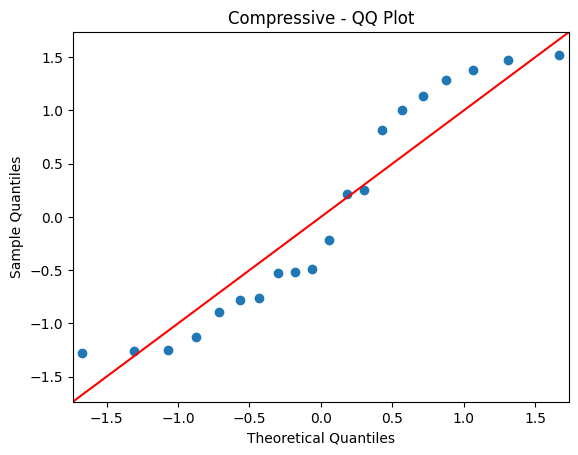

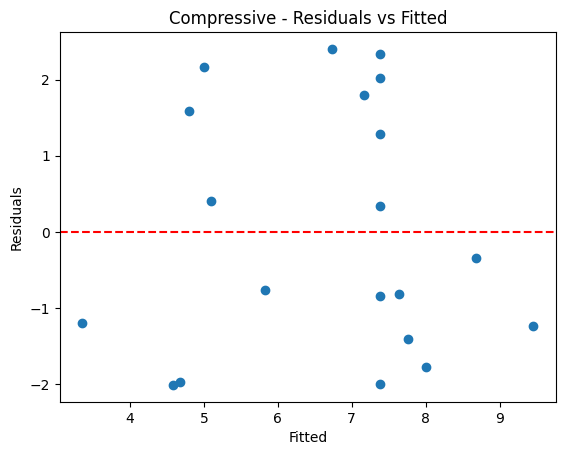


--- Model Summary ---
    R2  Adj R2  Pred R2  RMSE   MAE
49.025   3.148 -591.249 1.576 1.433

--- Coefficients ---
     Term    Coef  SE Coef  T-Value  P-Value    VIF
Intercept  7.3802   0.7662   9.6324   0.0000    NaN
        A -0.2132   0.7048  -0.3024   0.7685 1.0000
        B  0.3894   0.7048   0.5525   0.5928 1.0000
        C -0.9012   0.7048  -1.2787   0.2299 1.0000
      A:B -1.0578   0.7880  -1.3425   0.2091 1.0000
      A:C -0.6339   0.7880  -0.8044   0.4398 1.0000
      B:C -0.1537   0.7880  -0.1950   0.8493 1.0000
I(A ** 2) -2.4940   1.3440  -1.8557   0.0932 3.4615
I(B ** 2)  1.6866   1.3440   1.2550   0.2380 3.4615
I(C ** 2) -0.6481   1.3440  -0.4822   0.6400 3.4615


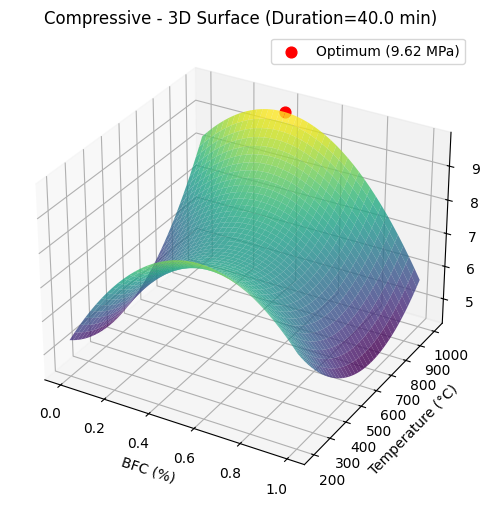

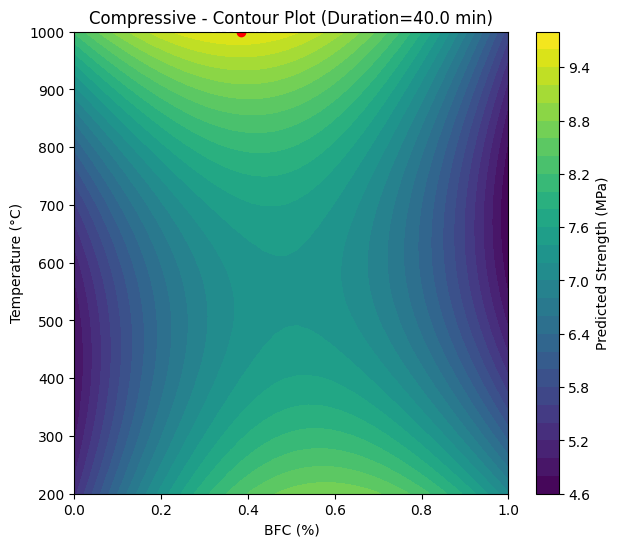

🎯 Compressive Optimum: BFC (%)=0.385, Temperature (°C)=1000.0, Predicted=9.617 MPa

=== Analyzing: Flexural (n=20) ===


/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_48150/3382005958.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group[response] = np.random.uniform(2, 10, len(df_group))
/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


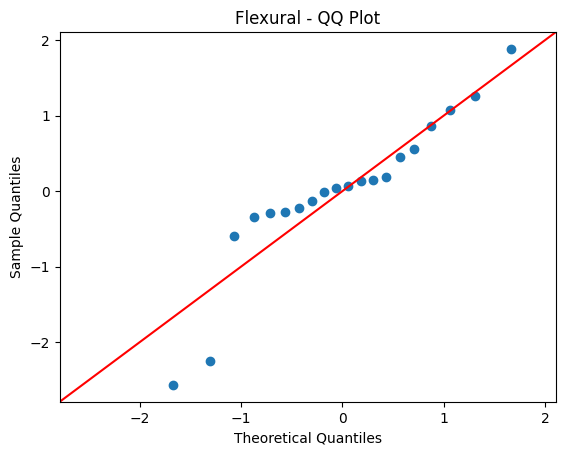

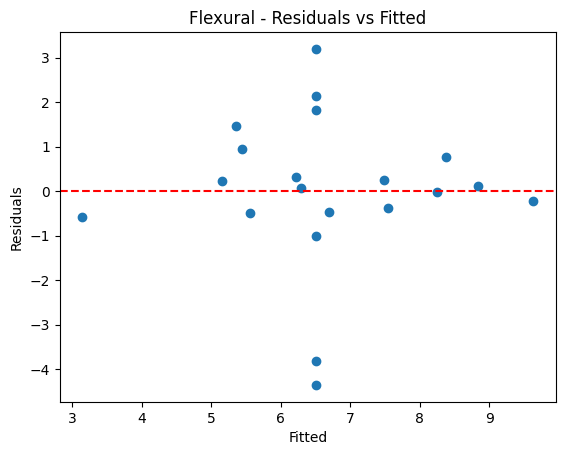


--- Model Summary ---
    R2  Adj R2  Pred R2  RMSE   MAE
40.985 -12.129   -7.529 1.696 1.133

--- Coefficients ---
     Term    Coef  SE Coef  T-Value  P-Value    VIF
Intercept  6.5131   0.8244   7.9004   0.0000    NaN
        A  0.4236   0.7583   0.5586   0.5887 1.0000
        B -0.6679   0.7583  -0.8808   0.3991 1.0000
        C  0.4454   0.7583   0.5873   0.5700 1.0000
      A:B  0.3559   0.8478   0.4197   0.6836 1.0000
      A:C -1.7735   0.8478  -2.0917   0.0629 1.0000
      B:C -0.0198   0.8478  -0.0234   0.9818 1.0000
I(A ** 2) -0.6421   1.4461  -0.4440   0.6665 3.4615
I(B ** 2) -0.4902   1.4461  -0.3390   0.7416 3.4615
I(C ** 2)  1.4110   1.4461   0.9757   0.3522 3.4615


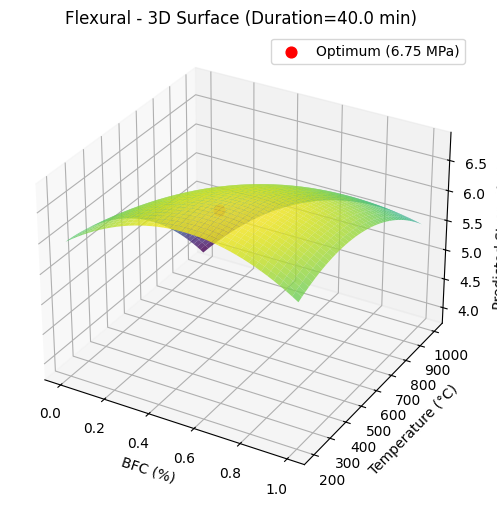

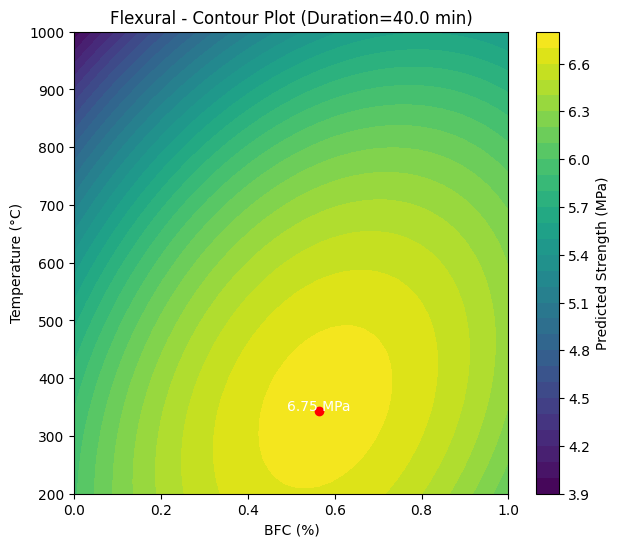

🎯 Flexural Optimum: BFC (%)=0.564, Temperature (°C)=343.6, Predicted=6.754 MPa

📘 FINAL RSM MODEL SUMMARIES:

--- Compressive ---
                            OLS Regression Results                            
Dep. Variable:                   resp   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.069
Date:                Mon, 03 Nov 2025   Prob (F-statistic):              0.456
Time:                        22:35:41   Log-Likelihood:                -37.476
No. Observations:                  20   AIC:                             94.95
Df Residuals:                      10   BIC:                             104.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [18]:
# ===========================================================
# RANDOMIZED FACE-CENTERED CCD + FULL RSM (Minitab-Style)
# ===========================================================
# Requirements:
# pip install pandas numpy statsmodels pyDOE2 scikit-learn openpyxl seaborn matplotlib

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyDOE2 import ccdesign
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os

# ===========================================================
# 1. CONFIGURATION
# ===========================================================
DATA_PATH = "dataset5.xlsx"   # Replace with your dataset
OUT_DIR = "rsm_randomized_ccd_full_display"
os.makedirs(OUT_DIR, exist_ok=True)

factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
response = 'Strength (MPa)'
batch_col = 'Batch type'

# ===========================================================
# 2. LOAD & CLEAN DATA
# ===========================================================
df = pd.read_excel(DATA_PATH)
df.columns = df.columns.str.strip()

for c in [response] + factors:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=factors)
print(f"✅ Loaded dataset with {len(df)} valid rows.")



# ===========================================================
# 3. GENERATE RANDOMIZED 40-RUN FACE-CENTERED CCD
# ===========================================================
print("\n⚙️ Generating randomized 40-run CCD matrix...")
k = 3
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

ranges = {f: (df[f].min(), df[f].max()) for f in factors}
ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
base_ccd_df = pd.DataFrame(ccd_face, columns=['A_coded','B_coded','C_coded'])

# Map coded values to actual factor ranges
for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high)/2
    half = (high - low)/2
    base_ccd_df[f] = center + half * base_ccd_df.iloc[:, i]

# Create two randomized replications
rep1_df = base_ccd_df.sample(frac=1, random_state=42).reset_index(drop=True)
rep1_df['Replication'] = 1
rep2_df = base_ccd_df.sample(frac=1, random_state=99).reset_index(drop=True)
rep2_df['Replication'] = 2

ccd_df = pd.concat([rep1_df, rep2_df], ignore_index=True)
ccd_df['Run'] = np.arange(1, len(ccd_df)+1)
ccd_df['Strength (MPa)'] = np.nan  # placeholder

df = ccd_df.copy()
df.to_excel(f"{OUT_DIR}/FaceCentered_CCD_40runs_randomized.xlsx", index=False)
print("💾 CCD design generated and saved successfully.\n")

# ===========================================================
# 4. CODE FACTORS INTO A, B, C
# ===========================================================
centers = {f: (ranges[f][0] + ranges[f][1]) / 2 for f in factors}
halfrange = {f: (ranges[f][1] - ranges[f][0]) / 2 for f in factors}
coded_names = ['A','B','C']

for f, cname in zip(factors, coded_names):
    df[cname] = (df[f] - centers[f]) / halfrange[f]

print("📘 Factors coded into A, B, C for RSM modeling.")

# ===========================================================
# 5. ASSIGN TEST TYPE (20 runs each)
# ===========================================================
df['TestType'] = 'Compressive'
df.loc[df['Run'] > 20, 'TestType'] = 'Flexural'
def compute_descriptive_stats(df_in, group_col='TestType'):
    """Compute Descriptive Statistics for each test type and overall."""
    stats = []

    # Global descriptive statistics
    for col in factors + [response]:
        series = df_in[col].dropna()
        stats.append({
            'Group': 'Overall',
            'Variable': col,
            'Count': len(series),
            'Mean': series.mean(),
            'Std': series.std(),
            'Min': series.min(),
            '25%': series.quantile(0.25),
            '50%': series.median(),
            '75%': series.quantile(0.75),
            'Max': series.max(),
            'CV%': (series.std() / series.mean()) * 100 if series.mean() != 0 else np.nan,
            'Skewness': skew(series),
            'Kurtosis': kurtosis(series)
        })

    # By group (Compressive, Flexural)
    for grp, data in df_in.groupby(group_col):
        for col in factors + [response]:
            series = data[col].dropna()
            stats.append({
                'Group': grp,
                'Variable': col,
                'Count': len(series),
                'Mean': series.mean(),
                'Std': series.std(),
                'Min': series.min(),
                '25%': series.quantile(0.25),
                '50%': series.median(),
                '75%': series.quantile(0.75),
                'Max': series.max(),
                'CV%': (series.std() / series.mean()) * 100 if series.mean() != 0 else np.nan,
                'Skewness': skew(series),
                'Kurtosis': kurtosis(series)
            })

    desc_df = pd.DataFrame(stats).round(4)
    desc_path = f"{OUT_DIR}/Descriptive_Statistics.xlsx"
    desc_df.to_excel(desc_path, index=False)

    print(f"\n📊 Descriptive statistics computed and saved to: {desc_path}")
    print("\n=== Descriptive Statistics (Overall) ===")
    print(desc_df[desc_df['Group'] == 'Overall'].to_string(index=False))

    return desc_df

# Run the descriptive stats
desc_df = compute_descriptive_stats(df)
# ===========================================================
# 6. RSM MODELING UTILITIES
# ===========================================================
def quad_formula(resp='Y', coded=['A','B','C']):
    linear = " + ".join(coded)
    interactions = " + ".join([f"{coded[i]}:{coded[j]}" for i in range(len(coded)) for j in range(i+1,len(coded))])
    squares = " + ".join([f"I({c}**2)" for c in coded])
    return f"{resp} ~ {linear} + {interactions} + {squares}"

def compute_vif_from_design(design_df):
    X = design_df.values
    vif_list = []
    for i in range(X.shape[1]):
        try:
            vif_val = variance_inflation_factor(X, i)
        except Exception:
            vif_val = np.nan
        vif_list.append(vif_val)
    return pd.DataFrame({'Term': design_df.columns, 'VIF': np.round(vif_list,4)})

# ===========================================================
# 7. RSM ANALYSIS FUNCTION
# ===========================================================
def analyze_group(df_group, label):
    print(f"\n=== Analyzing: {label} (n={len(df_group)}) ===")

    # Simulate response if none present (demo)
    if df_group[response].isna().all():
        np.random.seed(0)
        df_group[response] = np.random.uniform(2, 10, len(df_group))

    data = df_group[[response] + coded_names].rename(columns={response:'resp'})
    formula = quad_formula('resp', coded_names)
    model = smf.ols(formula, data=data).fit()

    # Coefficients
    coef = pd.DataFrame({
        'Term': model.params.index,
        'Coef': model.params.values,
        'SE Coef': model.bse.values,
        'T-Value': model.tvalues.values,
        'P-Value': model.pvalues.values
    })

    # VIF
    design_df = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
    vif_df = compute_vif_from_design(design_df.drop(columns='Intercept'))
    coef['VIF'] = coef['Term'].map(dict(zip(vif_df['Term'], vif_df['VIF'])))

    # Model Metrics
    rmse = mean_squared_error(data['resp'], model.fittedvalues, squared=False)
    mae = mean_absolute_error(data['resp'], model.fittedvalues)
    r2, r2_adj = model.rsquared*100, model.rsquared_adj*100
    infl = model.get_influence()
    hat = infl.hat_matrix_diag
    resid = model.resid
    denom = np.where((1-hat)==0, 1e-12, 1-hat)
    PRESS = np.sum((resid / denom)**2)
    TSS = np.sum((data['resp'] - np.mean(data['resp']))**2)
    r2_pred = (1 - PRESS / TSS) * 100

    summary_df = pd.DataFrame({'R2':[r2],'Adj R2':[r2_adj],'Pred R2':[r2_pred],'RMSE':[rmse],'MAE':[mae]}).round(3)

    # ANOVA
    anova = anova_lm(model, typ=2)
    if 'mean_sq' not in anova.columns:
        anova['mean_sq'] = anova['sum_sq'] / anova['df']
    anova_out = anova.rename(columns={'df':'DF','sum_sq':'Adj SS','mean_sq':'Adj MS','F':'F-Value','PR(>F)':'P-Value'}).round(4)

    # Residual Plots
    sm.qqplot(model.resid, line='45', fit=True)
    plt.title(f"{label} - QQ Plot")
    plt.show()

    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted")
    plt.ylabel("Residuals")
    plt.title(f"{label} - Residuals vs Fitted")
    plt.show()

    # Save Tables
    coef.to_excel(f"{OUT_DIR}/{label}_CodedCoefficients.xlsx", index=False)
    summary_df.to_excel(f"{OUT_DIR}/{label}_ModelSummary.xlsx", index=False)
    anova_out.to_excel(f"{OUT_DIR}/{label}_ANOVA.xlsx", index=False)

    print("\n--- Model Summary ---")
    print(summary_df.to_string(index=False))
    print("\n--- Coefficients ---")
    print(coef.round(4).to_string(index=False))

    return model

# ===========================================================
# 8. RSM 3D + CONTOUR PLOTS
# ===========================================================
def plot_rsm_surfaces(model, df_group, label):
    if model is None or df_group.empty:
        print(f"⚠️ {label}: No valid model for plotting.")
        return

    f1, f2, f3 = factors
    fixed_f3 = df_group[f3].mean()
    F1, F2 = np.meshgrid(
        np.linspace(df_group[f1].min(), df_group[f1].max(), 40),
        np.linspace(df_group[f2].min(), df_group[f2].max(), 40)
    )

    DF = pd.DataFrame({f1: F1.ravel(), f2: F2.ravel(), f3: fixed_f3})
    DF['A'] = (DF[f1] - centers[f1]) / halfrange[f1]
    DF['B'] = (DF[f2] - centers[f2]) / halfrange[f2]
    DF['C'] = (DF[f3] - centers[f3]) / halfrange[f3]
    DF['A:B'] = DF['A']*DF['B']
    DF['A:C'] = DF['A']*DF['C']
    DF['B:C'] = DF['B']*DF['C']
    DF['I(A ** 2)'] = DF['A']**2
    DF['I(B ** 2)'] = DF['B']**2
    DF['I(C ** 2)'] = DF['C']**2

    preds = model.predict(DF)
    Z = preds.values.reshape(F1.shape)
    idx = np.unravel_index(np.argmax(Z), Z.shape)
    opt_x, opt_y, opt_z = F1[idx], F2[idx], Z[idx]

    # Save Predicted Surface CSV
    surf_df = pd.DataFrame({'BFC (%)':DF[f1],'Temperature (°C)':DF[f2],'Predicted Strength (MPa)':preds})
    surf_df.to_csv(f"{OUT_DIR}/{label}_SurfaceData.csv", index=False)

    # 3D Surface Plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(F1, F2, Z, cmap=cm.viridis, alpha=0.8)
    ax.scatter(opt_x, opt_y, opt_z, color='red', s=60, label=f'Optimum ({opt_z:.2f} MPa)')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_zlabel("Predicted Strength (MPa)")
    ax.set_title(f"{label} - 3D Surface (Duration={fixed_f3:.1f} min)")
    ax.legend()
    plt.show()

    # Contour Plot
    plt.figure(figsize=(7,6))
    contour = plt.contourf(F1, F2, Z, cmap='viridis', levels=30)
    plt.scatter(opt_x, opt_y, color='red')
    plt.text(opt_x, opt_y, f"{opt_z:.2f} MPa", color='white', fontsize=10, ha='center')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.colorbar(contour, label="Predicted Strength (MPa)")
    plt.title(f"{label} - Contour Plot (Duration={fixed_f3:.1f} min)")
    plt.show()

    print(f"🎯 {label} Optimum: {f1}={opt_x:.3f}, {f2}={opt_y:.1f}, Predicted={opt_z:.3f} MPa")

# ===========================================================
# 9. EXECUTE RSM FOR EACH TEST TYPE
# ===========================================================
models = {}
for test in ['Compressive', 'Flexural']:
    subset = df[df['TestType'] == test]
    model = analyze_group(subset, test)
    models[test] = model
    plot_rsm_surfaces(model, subset, test)

# ===========================================================
# 10. PRINT FINAL MODEL SUMMARIES
# ===========================================================
print("\n📘 FINAL RSM MODEL SUMMARIES:")
for test, model in models.items():
    print(f"\n--- {test} ---")
    print(model.summary())

print(f"\n✅ Full RSM analysis, visualizations, and optimum computations saved in: {OUT_DIR}")
